# Handling continuous outcome

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as stsa
import statsmodels.formula.api as smf

%matplotlib inline
sns.set(style = 'whitegrid')

## Data

Continuous data are numeric and can take either whole numbers, positive real numbers, integers or any real numbers. Some of them are age (positive real numbers), weight (positive real numbers), number of lesions in CT scan of chest (positive integer, count data), etc.

These data can be summarised according to **value based methods** (mean, standard deviation) or by **rank based methods** (median, IQR, range)

For this lesson, we will analyse **distribution of blood hemoglobin (hb) and platelets among adult males and females**. We will create a random sample and then try to analyse it.

We will assume that the **underlying probabilistic process determining the hb among adult** is normal distribution with standard deviation of 3 g/dL. We also assume that the mean hb for male is 14 g/dL and for female is 12 g/dL (2 g/dL less than male).

For **platelets**, we will assume that the **logarithm of platelets are normally distributed** with standard deviation of 0.5 and mean of 5 for both males and females.

In [2]:
sd_hb = 3
mean_hb_male = 14
mean_hb_female = 12

mean_lplt_male = 5
mean_lplt_female = 5
sd_lplt = 0.5

hb_male = st.norm(loc = mean_hb_male, scale = sd_hb)
hb_female = st.norm(loc = mean_hb_female, scale = sd_hb)

lplt_male = st.norm(loc = mean_lplt_male, scale = sd_lplt)
lplt_female = st.norm(loc = mean_lplt_female, scale = sd_lplt)

np.random.seed(100)
N = 10

hb_males = hb_male.rvs(N)
hb_females = hb_female.rvs(N)

plt_males = 10 ** (lplt_male.rvs(N))
plt_females = 10 ** (lplt_female.rvs(N))

df = pd.DataFrame({'gender': np.repeat(['m', 'f'], N), 'hb': np.hstack([hb_males, hb_females]), \
                     'plt': np.hstack([plt_males, plt_females])})

**We have to remember we are ignorant about the above process.**

We have the dataframe `df` which contains a random sample of 10 for hemoglobin and platelets.

## Descriptive statistics

We will **describe the given sample**. It is a part of exploratory data analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gender  20 non-null     object 
 1   hb      20 non-null     float64
 2   plt     20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes


In [4]:
df.groupby('gender').describe().T

gender                 f              m
hb  count      10.000000      10.000000
    mean       11.916209      14.061709
    std         2.155885       2.662772
    min         8.645045       8.750704
    25%        10.461099      13.289897
    50%        11.186180      14.714272
    75%        13.839994      15.414003
    max        15.089198      17.459107
plt count      10.000000      10.000000
    mean   119527.455292  265217.288898
    std    132175.332916  228321.709748
    min     14278.795931   37912.474471
    25%     21784.364104   82775.479780
    50%     50511.075746  177837.541093
    75%    210239.457422  433149.065857
    max    393378.965607  644897.703401

<AxesSubplot:xlabel='gender', ylabel='hb'>

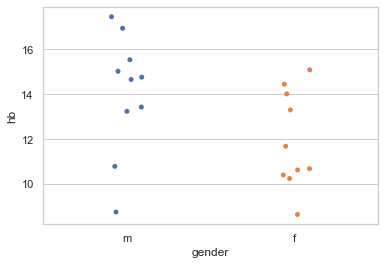

In [5]:
sns.stripplot(x = 'gender', y = 'hb', data = df)

<AxesSubplot:xlabel='gender', ylabel='plt'>

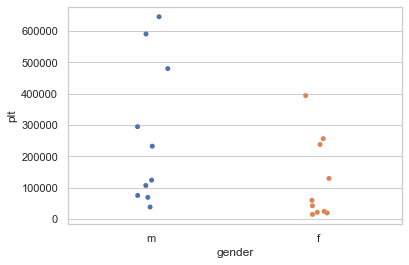

In [6]:
sns.stripplot(x = 'gender', y = 'plt', data = df)

Now we would like to **infer (estimate, guess)** about the **underlying population (probabilistic process)** which has generated the above sample.

## Effect size (parameter of underlying probabilistic process) {#effect}

Understanding the effect size is the most important requirement for a researcher.

It is a **property of the underlying data generating probability distribution (aka population)**.

Defining and designing an effect size for a particular problem needs a sound theoretical knowledge about the subject area.

Commonly used run of the mill **effect sizes** for continuous data are:

1. Mean, median

2. Difference between means

3. Difference between medians

**Goals** of inferential statistics are:

1. The above effect sizes are to be **estimated** from the given sample.

2. Hypothesised values of effect sizes are **rejected/not rejected** from the given sample.

## Comparing population mean against a hypothesised value {#comp1pop}

The first type of problem is to compare mean of the underlying process with a hypothesised value.

We want to analyse hb in males for the present problem.

We want to check the plausibility of **hypothesis that mean hb in males is 13 g/dL** and also **estimate mean hb of underlying process (normal distribution)**.

In [7]:
# given sample
hb_males

array([ 8.75070358, 15.02804121, 17.45910741, 13.24269189, 16.94396236,
       15.54265652, 14.66353901, 10.78987001, 13.43151251, 14.76500433])

In [8]:
# descriptive statistics class: statsmodels.stats.api.DescrStatsW
descr_hb_males = stsa.DescrStatsW(hb_males)

### H0: mean Hb = 13 g/dL

We can carry out **t test** or **z test** for **single sample** to solve the above problem.

If we have small sample (usually less than 30), approximately normally distributed and we want to estimate standard deviation of underlying process from the sample we use **t test**.

For sample larger than 30, we can use **z test**, even if the sample is non-normal (skewed).

For smaller non-normal (skewed) samples, we prefer using [**rank based** tests](#skew).

For larger samples, **t test** and **z test** are roughly equivalent.

Let us recapitulate the **steps for hypothesis testing**

1. Define effect size (mean of Hb)

2. Get null hypothesis (mean Hb: 13) (Underlying probability distribution **t distribution, degree of freedom = 9**).

3. Get **probability distribution of all possible outcomes (all possible mean Hb)** under the null hypothesis probabilistic process (will be done by the function)

4. Calculate probability of obtaining as **extreme or more extreme** mean Hb than the present sample (**p value**) (will be done by the function).

5. If **p value < 0.05**, we **reject the probabilistic process under null hypothesis** (we reject that the mean Hb of males is 13 g/dL). See [pitfall 2 earlier chapter](3-inferential-stats.ipynb#pitfall2) for the pitfall in this approach.

In [9]:
# Null hypothesis Hb in males = 13
print(f'p value for mean hb of 13 g/dl = {descr_hb_males.ttest_mean(value = 13)[1]:.3f}')

p value for mean hb of 13 g/dl = 0.239


As the **p > 0.05**, we are **not able to reject** the null hypothesis probability process with mean Hb of 13 g/dL.

Although the **real** mean Hb for male is 14 g/dL (**which is hidden from us**), but with the given sample, **mean Hb of 13 g/dL is equally plausible**.

### Estimating mean Hb for male

We will calculate **95% confidence interval** to get the **interval containing all plausible values (values which cannot be rejected when tested with the given sample) of mean Hb for male** and we will be **correct 95% of times**.

In [10]:
ci = descr_hb_males.tconfint_mean(alpha=0.05)
print(f'95% confidence interval of mean hb for male: {ci[0]:.3f} - {ci[1]:.3f}')

95% confidence interval of mean hb for male: 12.157 - 15.967


It is important to realise that the **above interval is not a probability distribution**.

## Comparing two population means

We are going to **compare means of underlying probabilistic processes (hb) between two groups (male and female)**.

When we do so, we are actually **comparing mean of a single probabilistic process** (which is **difference between means of both probabilistic processes**) against a **hypothesised value of no difference (0)**, just as we did in the [above section](#comp1pop). 

In [11]:
hb_males

array([ 8.75070358, 15.02804121, 17.45910741, 13.24269189, 16.94396236,
       15.54265652, 14.66353901, 10.78987001, 13.43151251, 14.76500433])

In [12]:
hb_females

array([10.62591904, 13.30549046, 10.24921485, 14.45054122, 14.01816242,
       11.68676657, 10.40615887, 15.08919806, 10.68559313,  8.64504526])

In [13]:
print(f'''sample mean hb in males: {hb_males.mean():.3f}
sample mean hb in females: {hb_females.mean():.3f}
difference between sample mean hb (males - females): {hb_males.mean() - hb_females.mean():.3f}''')

sample mean hb in males: 14.062
sample mean hb in females: 11.916
difference between sample mean hb (males - females): 2.145


In [14]:
# compare mean class: statsmodels.stats.api.CompareMeans
meandiff_hb = stsa.CompareMeans(stsa.DescrStatsW(df.loc[df.gender == 'm', 'hb'].values), \
                               stsa.DescrStatsW(df.loc[df.gender == 'f', 'hb'].values))

In [15]:
print(f'p value for difference in mean hb of 0 = {meandiff_hb.ttest_ind(value = 0)[1]:.3f}')

p value for difference in mean hb of 0 = 0.063


In [16]:
ci_diff = meandiff_hb.tconfint_diff(alpha=0.05)
print(f'95% confidence interval of difference in mean hb for male and female: {ci_diff[0]:.3f} - {ci_diff[1]:.3f}')

95% confidence interval of difference in mean hb for male and female: -0.131 - 4.422


Our test is **not able to reject the null hypothesis of no difference** in mean hb between male and female (which is the effect size of the probabilistic process under null hypothesis), as **p > 0.05**.

Also **95% confidence interval** contains all values (of difference in mean between male and female) between **-0.131 to 4.422**. As it includes the mean of no difference (0), we say that we are not able to reject the null hypothesis of no difference.

It is interesting to note that **in reality** (which is **hidden** from us), there is a **difference in means of hb between male and female of 2 g/dL**, but our test did not have the power to detect the difference and based on the given sample, we are only able to estimate the difference to be any value between -0.131 to 4.422.

In [17]:
# power of the test
stsa.tt_ind_solve_power(effect_size = 2 / 3, alpha = 0.05, nobs1 = 10)

0.2921099804102457

As can be seen from above, the power of the test is only 0.292. We will be able to detect the required effect size (difference of 2 g/dL), given the sample size of 10 only 29.2% of the times. It is considered to be **too small**. We say that our **test was not powered** enough to detect the required effect size (difference of 2 g/dL).

## Sample size calculation {#samp-size-cont}

As we have seen in previous lecture, **increasing sample size** is one of few ways to increase power of any test.

Let us say, we want to know minimum sample size, which will be able to detect the **difference** between mean hb between male and female of **2 g/dL** (which is **clinically relevant** to us). We want to be correct in getting the difference 80% of times (**power = 0.8**) and we accept the error of telling that the sample does not belong to the null hypothesis probabilistic process (when actually the sample does belong to the null hypothesis process) 5% of times (**alpha error = 0.05**).

In [18]:
stsa.tt_ind_solve_power(effect_size = 2 / 3, alpha = 0.05, power = 0.8)

36.305687896793614

So, we need a sample size of **36 males** and **36 females** to achieve **power of 0.8**.

The following figure depicts the sample size and power of the test for different effect sizes. It shows that **more sample size** is required if we want to **detect smaller difference** (smaller effect size) and we want to **increase power** to detect the difference.

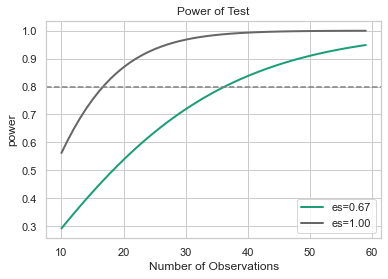

In [19]:
f, ax = plt.subplots()
f = stsa.TTestIndPower().plot_power(nobs = np.arange(10, 60), effect_size = [2/3, 1], ax = ax)
ax.axhline(0.8, linestyle = 'dashed', color = 'gray')
_ = ax.set_ylabel('power')

## Handling skewed data {#skew}

When we are dealing with **small skewed data**, we prefer using **rank based tests**, as the value based tests (like t test) become less powered.

We will use platelets for males and females to understand analysis of a skewed data.

We recollect that there is no difference in probabilistic process generating platelets in male and female (we are, obviously, unaware of it).

### Rank based tests

**Kruskal Wallis Test:** checks null hypothesis that population median of all the groups are equal.

In [20]:
print(f"p value of hypothesis that median of plts for male and female are equal: {st.kruskal(df.loc[df.gender == 'm', 'plt'], df.loc[df.gender == 'f', 'plt']).pvalue:.3f}")

p value of hypothesis that median of plts for male and female are equal: 0.070


In [21]:
print(f"p value for t test of equality of means: {st.ttest_ind(df.loc[df.gender == 'm', 'plt'], df.loc[df.gender == 'f', 'plt']).pvalue:.3f}")

p value for t test of equality of means: 0.098


**p values** of rank based test (Kruskal Wallis test) and value based test (t test) are more than 0.05. So, we are **not able to reject the hypothesis of no difference** between medians and means between males and females.

### Logarithmic transformation

By [**logarithm transformation**](21-eda.ipynb#logtr) we can **convert a right skewed data into symmetrical data**. We can then use our value based tests to analyse the effect size.

In [22]:
stsa.CompareMeans(stsa.DescrStatsW(np.log10(df.loc[df.gender == 'm', 'plt'])), \
                  stsa.DescrStatsW(np.log10(df.loc[df.gender == 'f', 'plt']))).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

## Linear regression models

**Regression models** are a general category of models which attempt to **explain a response variable** with one or many **explanatory variables**.

**Linear regression models** are regression models in whom the **response variable is a continuous one** and the **explanatory variables are related** to the response variable **additively**.

For a valid application of linear regression analysis following assumptions are to be satisfied:

1. **Response variable** is a continuous and is normally distributed.

2. **Explanatory variables** are not correlated to each other and are not related to the error term.

3. **Variance of response variable** is constant and doesnot depend on the explanatory variables and value of response variable.

We will introduce ourselves to univariate linear regression analysis. We will not deal with diagnostics of validity of model and will not deal with multivariate linear regression analysis.

Let us say, we want to analyse **relation of hemoglobin with log of platelet counts** for the above example.

Linear regression model will **explain** the relation as follows:

$$
hemoglobin = intercept + slope * logplt + error
$$

It says that the relation of mean of hemoglobin and log platelet is a linear one, that is it can be explained by a **straight line**.

The **association between the two** is depicted by the **slope of the line** (with slope of 0 meaning no relation, positive slope meaning there is a positive relation and negative slope meaning there is a negative slope).

**Slope** is defined as **change in hemoglobin with one unit change in log platelets**.

In [23]:
# model is described as 'response variable ~ transformation(explanatory variable)'

lin_mod_hb_lplt = smf.ols('hb ~ np.log(plt)', data = df)

In [24]:
lin_mod_hb_lplt_fit = lin_mod_hb_lplt.fit()

In [25]:
lin_mod_hb_lplt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     hb   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                   0.02060
Date:                Tue, 09 Nov 2021   Prob (F-statistic):              0.887
Time:                        20:35:23   Log-Likelihood:                -46.982
No. Observations:                  20   AIC:                             97.96
Df Residuals:                      18   BIC:                             99.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1457      5.906      2.057      0.055      -0.262      24.553
np.log(plt)     0.0729      0.508      0.144      0.887      -0.994       1.139
==============================================================================
Omnibus:                        1.522   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.467   Jarque-Bera (JB):                0.933
Skew:                          -0.112   Prob(JB):                        0.627
Kurtosis:                       1.966   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# coefficient: np.log(plt) is the SLOPE
lin_mod_hb_lplt_fit.params

Intercept      12.145650
np.log(plt)     0.072865
dtype: float64

In [27]:
# 95% CI
lin_mod_hb_lplt_fit.conf_int()

0          1
Intercept   -0.262199  24.553500
np.log(plt) -0.993718   1.139448

Since **95% CI of slope of line includes 0** (null hypothesis of no relation), so we are **not able to reject the null hypothesis of no relation.**